In [1]:
import os
from skimage import data, color, exposure
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import glob
import cv2 as cv


In [2]:

images_test_pos = []
for img_path in glob.glob('Test/pos/*.*'):
    images_test_pos.append(imread(img_path))
    
images_train_pos = []
for img_path in glob.glob('Train/pos/*.*'):
    images_train_pos.append(imread(img_path))
    
    
images_test_neg = []
for img_path in glob.glob('Test/neg/*.*'):
    images_test_neg.append(cv.imread(img_path,1)) 
    
images_train_neg = []
for img_path in glob.glob('Train/neg/*.*'):
    images_train_neg.append(cv.imread(img_path,1)) 
    


In [3]:
img_train_pos_resize = []
img_train_neg_resize = []
for pos_img_file in images_train_pos:
    img_train_pos_resize.append(cv.resize(pos_img_file,(64,128)))
    
for neg_img_file in images_train_neg:
    img_train_neg_resize.append(cv.resize(pos_img_file,(64,128)))
    

In [4]:
from skimage import feature
from skimage import exposure
from tqdm.notebook import tqdm

#initialize list that contains training images
train_data = []
# count of all training images to use in loop
train_img_count = len(img_train_pos_resize)

def compute_HOG(image):
  (H1, hogImage1) = feature.hog(image, orientations = 3,
                                pixels_per_cell  = (8, 8), cells_per_block  = (2, 2), transform_sqrt=True,
                                block_norm  = 'L1' , visualize=True)
  return (H1, hogImage1)

train_lbl = []
# loop over the images
for i in tqdm(range(0,train_img_count)):
    # Computing the HOG features. Also Keep and 
    #eye on the parameters used in this function call.
    (h_vector, h_image) = compute_HOG(img_train_pos_resize[i])
    #append computed HOGs in train data
    train_data.append(h_vector)
    train_lbl.append(1)

    
train_img_count = len(img_train_neg_resize)

for i in tqdm(range(0,train_img_count)):
    # Computing the HOG features. Also Keep and 
    #eye on the parameters used in this function call.
    (h_vector, h_image) = compute_HOG(img_train_neg_resize[i])
    #append computed HOGs in train data
    train_data.append(h_vector)
    train_lbl.append(-1)
    
total_length = len(img_train_pos_resize) + len(img_train_neg_resize)

#get train labels
train_label = train_lbl[0:total_length]

In [5]:
img_test_pos_resize = []
img_test_neg_resize = []
for pos_img_file in images_test_pos:
    img_test_pos_resize.append(cv.resize(pos_img_file,(64,128)))
    
for neg_img_file in images_test_neg:
    img_test_neg_resize.append(cv.resize(pos_img_file,(64,128)))
    

In [6]:
test_data=[]
test_lbl = []
test_img_count = len(img_test_pos_resize)

for i in tqdm(range(0,test_img_count)):
    # pre-process image here if needed
    # Computing the HOG features. Also Keep and eye on the parameters used in this function call.
    (h_vector, h_image) = compute_HOG(img_test_pos_resize[i])
    #append computed HOGs in train data
    test_data.append(h_vector)
    test_lbl.append(1)

test_img_count = len(img_test_neg_resize)

for i in tqdm(range(0,test_img_count)):
    # pre-process image here if needed
    # Computing the HOG features. Also Keep and eye on the parameters used in this function call.
    (h_vector, h_image) = compute_HOG(img_test_neg_resize[i])
    #append computed HOGs in train data
    test_data.append(h_vector)
    test_lbl.append(-1)
    
total_length = len(img_train_pos_resize) + len(img_test_neg_resize)

#get train labels
test_label = test_lbl[0:total_length]

In [7]:
from sklearn.svm import LinearSVC

# load linear SVM
modelSVC = LinearSVC()
modelSVC.fit(train_data, train_label)
print("SVC training completed")



SVC training completed


In [8]:
from sklearn.ensemble import RandomForestRegressor 

model_random_forest = RandomForestRegressor() 
  
# fit the regressor with x and y data 
model_random_forest.fit(train_data, train_label)   
print("Random Forest training completed")

Random Forest training completed


In [9]:
import joblib
#from sklearn.externals import joblib

joblib.dump(modelSVC, 'person_detector_svm.pkl', compress=9)
joblib.dump(model_random_forest, 'person_detector_random_forest.pkl', compress=9)

['person_detector_random_forest.pkl']

In [10]:
predicted_labels_svm = modelSVC.predict(test_data)
print("Prediction completed")
print("Comparing predicted and actual labels of SVM")
print(predicted_labels_svm[0:10])
print(np.array(test_label[0:10]))

predicted_labels_rf = model_random_forest.predict(test_data)
print("Prediction completed")
print("Comparing predicted and actual labels of Random Forest")
print(predicted_labels_rf[0:10])
print(np.array(test_label[0:10]))

Prediction completed
Comparing predicted and actual labels of SVM
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
Prediction completed
Comparing predicted and actual labels of Random Forest
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1 1 1 1 1 1 1 1 1 1]


In [13]:
from sklearn.metrics import recall_score
# SVM True Positive Rate and False Negative Rate
tpr = recall_score(test_label, predicted_labels_svm, average='micro')
tnr = recall_score(test_label, predicted_labels_svm, pos_label = -1, average='micro') 
fpr = 1 - tnr
fnr = 1 - tpr
print("True Positive of SVM ",tpr)
print("False Positive of SVM",fpr)

# SVM True Positive Rate and False Negative Rate
tpr = recall_score(test_label, predicted_labels_rf.round(), average='micro')
tnr = recall_score(test_label, predicted_labels_rf.round(), pos_label = -1, average='micro') 
fpr = 1 - tnr
fnr = 1 - tpr
print("True Positive of Random Forest ",tpr)
print("False Positive of Random Forest",fpr)

True Positive of SVM  0.7141955835962145
False Positive of SVM 0.2858044164037855
True Positive of Random Forest  0.7135646687697161
False Positive of Random Forest 0.28643533123028386


In [14]:
from sklearn import metrics

print("Accuracy of SVM:",metrics.accuracy_score(test_label, predicted_labels_svm))
print("Accuracy of Random Forest:",metrics.accuracy_score(test_label, predicted_labels_rf.round()))

Accuracy of SVM: 0.7141955835962145
Accuracy of Random Forest: 0.7135646687697161


In [15]:
from sklearn.metrics import f1_score

print("F1 Score of SVM:",f1_score(test_label, predicted_labels_svm))
print("F1 Score of Random Forest:",f1_score(test_label, predicted_labels_rf.round(),average='micro'))

F1 Score of SVM: 0.8332719911667279
F1 Score of Random Forest: 0.7135646687697161


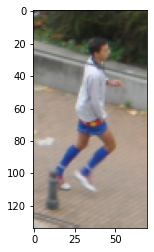

Actual Label :  1
SVM Predicted Label :  1
Random Forest Predicted Label :  1.0


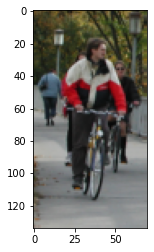

Actual Label :  1
SVM Predicted Label :  1
Random Forest Predicted Label :  1.0


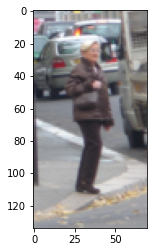

Actual Label :  1
SVM Predicted Label :  1
Random Forest Predicted Label :  1.0


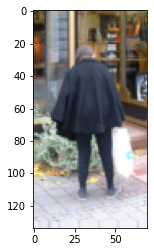

Actual Label :  1
SVM Predicted Label :  1
Random Forest Predicted Label :  1.0


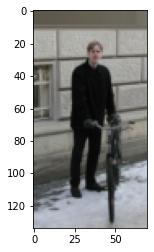

Actual Label :  1
SVM Predicted Label :  1
Random Forest Predicted Label :  1.0


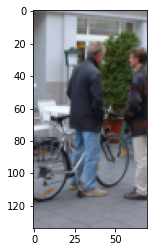

Actual Label :  1
SVM Predicted Label :  1
Random Forest Predicted Label :  1.0


In [16]:
for i in range(6):
    plt.imshow(images_test_pos[i])
    plt.show()
    print("Actual Label : ",test_label[i])
    print("SVM Predicted Label : ",predicted_labels_svm[i])
    print("Random Forest Predicted Label : ",predicted_labels_rf[i] )